# Classification
## BBC dataset
Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
Natural Classes: 5 (business, entertainment, politics, sport, tech)

If you make use of the dataset, please consider citing the publication: 
- D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

All rights, including copyright, in the content of the original articles are owned by the BBC.

Contact Derek Greene <derek.greene@ucd.ie> for further information.
http://mlg.ucd.ie/datasets/bbc.html

### Setup 

In [274]:
import os
import glob
import re
import datetime
from collections import defaultdict, Counter
from itertools import chain

import numpy as np
import pandas as pd
import nltk
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelBinarizer 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Activation, Dropout 
from utils.metrics import confusion_matrix_seaborn

In [2]:
def dts():
    return datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

In [3]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='text_clf.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [4]:
logger.info('testing')

In [5]:
input_folders = glob.glob('../datasets/bbc/*')

In [6]:
input_folders

['../datasets/bbc/business',
 '../datasets/bbc/corpus.csv',
 '../datasets/bbc/entertainment',
 '../datasets/bbc/politics',
 '../datasets/bbc/README.TXT',
 '../datasets/bbc/sport',
 '../datasets/bbc/tech']

In [12]:
%%time
# read the data for each category from the file and create a dictionary with key, the name of the category and 
# value, list of content of files of that category
bbc_data = defaultdict(list)

for folder in input_folders:
    if os.path.isdir(folder):
        logger.warning(f'Reading files in, {folder}')
        category = folder.rsplit('/', 1)[1]
        for file in glob.glob(folder + '/*'):
            with open(file, 'r', encoding='latin-1') as file_obj:
                bbc_data[category].append(file_obj.read())

CPU times: user 15.6 ms, sys: 281 ms, total: 297 ms
Wall time: 302 ms


In [13]:
# convert defaultdict to pandas dataframe
df = pd.DataFrame()

for cat, cat_story in bbc_data.items():
    df_dummy = pd.DataFrame()
    df_dummy['story'] = cat_story
    df_dummy['topic'] = cat
    
    df = pd.concat([df, df_dummy])

In [14]:
df[['topic', 'story']].to_csv('../datasets/bbc/corpus.csv', index=False)

In [5]:
df = pd.read_csv('../datasets/bbc/corpus.csv')

In [6]:
def display_all(df):
    with pd.option_context('display.max_colwidth', 400):
        display(df)

In [7]:
display_all(df.tail())

,topic,story
2220,tech,"BT program to beat dialler scams\n\nBT is introducing two initiatives to help beat rogue dialler scams, which can cost dial-up net users thousands.\n\nFrom May, dial-up net users will be able to download free software to stop computers using numbers not on a user's ""pre-approved list"". Inadvertently downloaded by surfers, rogue diallers are programs which hijack modems and dial up a premium ra..."
2221,tech,"Spam e-mails tempt net shoppers\n\nComputer users across the world continue to ignore security warnings about spam e-mails and are being lured into buying goods, a report suggests.\n\nMore than a quarter have bought software through spam e-mails and 24% have bought clothes or jewellery. As well as profiting from selling goods or services and driving advertising traffic, organised crime rings c..."
2222,tech,"Be careful how you code\n\nA new European directive could put software writers at risk of legal action, warns former programmer and technology analyst Bill Thompson.\n\nIf it gets its way, the Dutch government will conclude its presidency of the European Union by pushing through a controversial measure that has been rejected by the European Parliament, lacks majority support from national gove..."
2223,tech,"US cyber security chief resigns\n\nThe man making sure US computer networks are safe and secure has resigned after only a year in his post.\n\nAmit Yoran was director of the National Cyber Security Division within the US Department of Homeland Security created following the 9/11 attacks. The division was tasked with improving US defences against malicious hackers, viruses and other net-based t..."
2224,tech,"Losing yourself in online gaming\n\nOnline role playing games are time-consuming, but enthralling flights from reality. But are some people taking their fantasy lives too seriously?\n\nWhen video game World of Warcraft hit the shops in Europe last week fans wrote in to the BBC website to express their delight - and to offer a warning. ""An addiction to a game like this is far more costly in tim..."


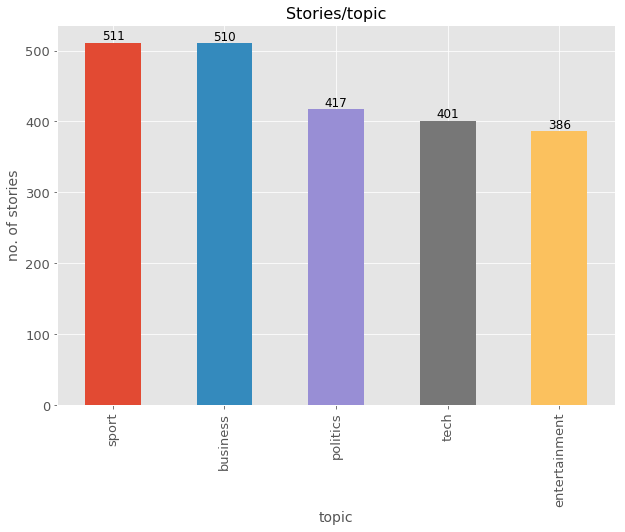

In [8]:
# Number of stories per topic 
ax = df['topic'].value_counts().plot(kind='bar', figsize=(10, 7), fontsize=13)
ax.set_title('Stories/topic', fontsize=16)
ax.set_xlabel('topic', fontsize=14)
ax.set_ylabel('no. of stories', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+4, i.get_height(), fontsize=12)

+ Data is not so imbalanced, it is okay to proceed with classification. No need to upsample or downsample the data.
+ <p style='color:darkgreen'>Different sources give different justifications on up-sampling and down-sampling. Finally, it is good to up-sample first and then down-sample, then compare the results of both.</p>

In [13]:
def clean_text(story):
    story = re.sub(r"\n+", ". ", story)
    story = re.sub(r"\'s", "", story)
    story = re.sub(r"\'ve", "", story)
    story = re.sub(r"n\'t", "", story)
    story = re.sub(r"\'re", "", story)
    story = re.sub(r"\'d", "", story)
    story = re.sub(r"\'ll", "", story)
    story = re.sub(r",", "", story)
    story = re.sub(r"!", " ! ", story)
    story = re.sub(r"\(", "", story)
    story = re.sub(r"\)", "", story)
    story = re.sub(r"\?", "", story)
    story = re.sub(r"'", "", story)
    story = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", story)
    story = re.sub(r"[0-9]\w+|[0-9]","", story)
    story = re.sub(r"\s{2,}", " ", story)
    story = story.strip().lower()
    story = [word for word in story.split() if word not in ENGLISH_STOP_WORDS]
    story = ' '.join(story)
    return story

In [14]:
print(clean_text(df['story'][0]))

ad sales boost time warner profit quarterly profits media giant timewarner jumped months december year earlier firm biggest investors google benefited sales high speed internet connections higher advert sales timewarner said fourth quarter sales rose profits buoyed gains offset profit dip warner bros users aol time warner said friday owns search engine google internet business aol mixed fortunes lost subscribers fourth quarter profits lower preceding quarters company said aol underlying profit exceptional items rose stronger internet advertising revenues hopes increase subscribers offering online service free timewarner internet customers try sign aol existing customers high speed broadband timewarner restate results following probe securities exchange commission sec close concluding time warner fourth quarter profits slightly better analysts expectations film division saw profits slump helped box office flops alexander catwoman sharp contrast year earlier final film lord rings trilogy

In [15]:
print(df['story'][0])

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AO

+ Cleaned text looks okay, not good though. We messed up firm names, U.S to us, percentages, currency representations e.t.c

In [16]:
df['processed_story'] = df['story'].apply(clean_text)

In [17]:
words_of_stories = chain.from_iterable(df['processed_story'].apply(lambda x: x.split()))

In [18]:
word_count = Counter(words_of_stories)

In [19]:
# size of vocabulary
len(word_count)

27655

+ Vocabulary size with stop words and basic cleaning: 29457
+ Vocabulary size without stop words and basic cleaning: 29160
+ Vocabulary size with well-defined preprocessing: 27655

In [20]:
word_count.most_common(10)

[('said', 7253),
 ('mr', 3005),
 ('year', 2309),
 ('people', 2045),
 ('new', 1978),
 ('time', 1322),
 ('world', 1201),
 ('government', 1160),
 ('uk', 1115),
 ('years', 1003)]

In [21]:
lb = LabelBinarizer()
lb.fit(df['topic'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [22]:
lb.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype='<U13')

In [23]:
train, test = train_test_split(df, test_size=0.2, stratify=df['topic'], shuffle=True, random_state=1310)

In [24]:
X_train_raw = train['processed_story'].copy()
X_test_raw = test['processed_story'].copy()
y_train_raw = train['topic'].copy()
y_test_raw = test['topic'].copy()
y_train = lb.transform(train['topic'])
y_test = lb.transform(test['topic'])

In [176]:
(X_train_raw.shape, y_train.shape), (X_test_raw.shape, y_test.shape)

(((1780,), (1780, 5)), ((445,), (445, 5)))

In [26]:
# Choosing ML model for classification based on s/w ratio
# No. of samples in the dataset
s = len(df['processed_story'])
# Get median of words per sample in the corpus 
w = np.median([len(story.split()) for story in df['processed_story']])
print(f"Number of samples in the dataset (s): {s}\nMedian of words per sample in the corpus (w): {w}\n\ns/w: {s/w:.2f}")

Number of samples in the dataset (s): 2225
Median of words per sample in the corpus (w): 175.0

s/w: 12.71


+ We have vocabulary size of 27655. We will select top 20,000 features using statistical tests (f_classif: F-value, chi2: Chi-Square)
+ There are other methods as well for feature selction in multi-class classification problem
    + Variance Threshold
    + ANOVA F-value
    + Chi-Squared
    + Information Gain

In [27]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000               # top K features
TOKEN_MODE = 'word'         # word or character n-gram 
MIN_DOCUMENT_FREQUENCY = 2  # minimum document/corpus frequency which a token will be discarded 

In [223]:
def n_gram_vectorize(X_train_raw, y_train_raw, X_test_raw, feature_slection_test=f_classif):
    """
    tfidf vector length  = length of vocabulary of unigrams + bigrams
    
    Parameters:
    -----------
    X_train_raw: array of features of training examples
    y_train_raw: array of training labels
    X_test_raw: array of features of test examples
    
    Returns:
    --------
    X_train, X_test: vectorized training and test texts
    """
    kwargs = {
        'ngram_range': NGRAM_RANGE,
        'dtype': np.float32, 
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,
        'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)
    X_train = vectorizer.fit_transform(X_train_raw)
    X_test = vectorizer.transform(X_test_raw)
    print(f"Actual features: {X_train.shape[1]}")
    # Select top 'k' features of the vectorized features
    selector = SelectKBest(score_func=feature_slection_test, k=min(TOP_K, X_train.shape[1]))
    selector.fit(X_train, y_train_raw)
    X_train = selector.transform(X_train).astype('float32')
    X_test = selector.transform(X_test).astype('float32')
    return X_train, X_test, vectorizer

In [224]:
%%time
X_train, X_test, vectorizer = n_gram_vectorize(X_train_raw, y_train_raw, X_test_raw, feature_slection_test=chi2)

Actual features: 57302
CPU times: user 1.3 s, sys: 78.1 ms, total: 1.38 s
Wall time: 1.37 s


## Top K important features of each category

In [262]:
def top_k_correlated_features_per_category(X_train, y_train_raw, k=2):
    """
    Parameters:
    -----------
    X_train: (n_samples, n_features), samples with their feature vectors
    y_train_raw: (n_samples,), category of each sample
    """
    for category in np.unique(y_train_raw):
        # calculates chi2 for each feature w.r.t each category, y_train_raw == category, converts category column to boolean
        features_chi2 = chi2(X_train, y_train_raw == category)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(vectorizer.get_feature_names())[indices]
        unigrams = [feature for feature in feature_names if len(feature.split()) == 1]
        bigrams = [feature for feature in feature_names if len(feature.split()) == 2]
        print(f"# {category}")
        print("  - Most correlated unigrams:\n     *{}".format('\n     *'.join(unigrams[-k:])))
        print("  - Most correlated bigrams:\n     *{}".format('\n     *'.join(bigrams[-k:])))

In [263]:
top_k_correlated_features_per_category(X_train, y_train_raw, 2)

# business
  - Most correlated unigrams:
     *austria
     *brainchild
  - Most correlated bigrams:
     *deficit china
     *aims cut
# entertainment
  - Most correlated unigrams:
     *allowing
     *aimed
  - Most correlated bigrams:
     *accept negotiations
     *called bankash
# politics
  - Most correlated unigrams:
     *attacking
     *concept
  - Most correlated bigrams:
     *brian harvey
     *amplification crystalline
# sport
  - Most correlated unigrams:
     *collected
     *beloved
  - Most correlated bigrams:
     *country operates
     *british industry
# tech
  - Most correlated unigrams:
     *deletion
     *felt
  - Most correlated bigrams:
     *cummings head
     *following relatively


## Fully Connected Multi-layer Perceptron

In [98]:
def nn_model():
    model = Sequential()
    model.add(Dense(150, input_shape=(X_train.shape[1],), kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    # model.add(Dense(150, kernel_initializer='he_normal'))
    # model.add(Activation('relu'))
    # model.add(Dense(150, kernel_initializer='he_normal'))
    # model.add(Activation('relu'))
    model.add(Dense(100, kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    # model.add(Dense(50, kernel_initializer='he_normal'))
    # model.add(Activation('relu'))
    model.add(Dense(len(lb.classes_), kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [99]:
%%time
model = nn_model()
history = model.fit(X_train, y_train, batch_size=320, epochs=10, validation_split=0.1, verbose=0)

CPU times: user 14.2 s, sys: 1.14 s, total: 15.4 s
Wall time: 4.51 s


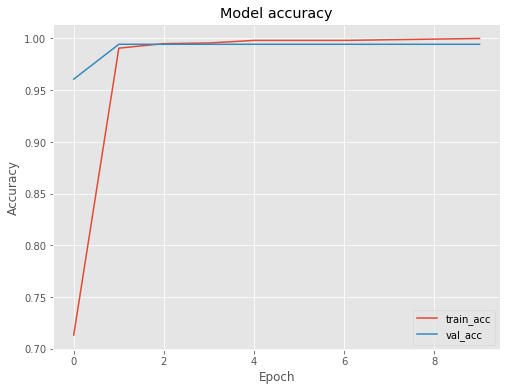

In [100]:
# training accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_acc', 'val_acc'], loc='lower right')
plt.show()

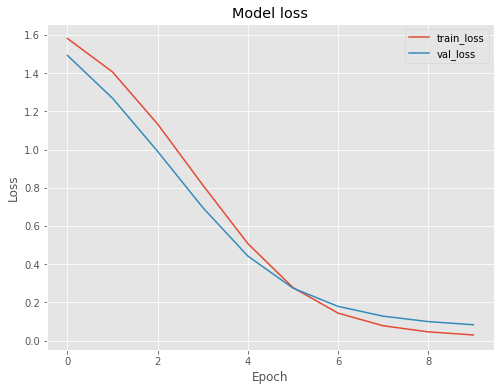

In [101]:
# training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

In [102]:
print(f"Overall accuracy of the model: {np.mean(history.history['acc'])*100:.2f}%\nAccuracy at final epoch: {history.history['acc'][-1]*100:.2f}%")

Overall accuracy of the model: 96.87%
Accuracy at final epoch: 100.00%


In [103]:
scores = model.evaluate(X_test, y_test, verbose=0)

In [104]:
print(f"Test accuracy: {scores[1]*100:.2f}%")

Test accuracy: 98.20%


In [105]:
y_pred = lb.classes_[model.predict_classes(X_test)]

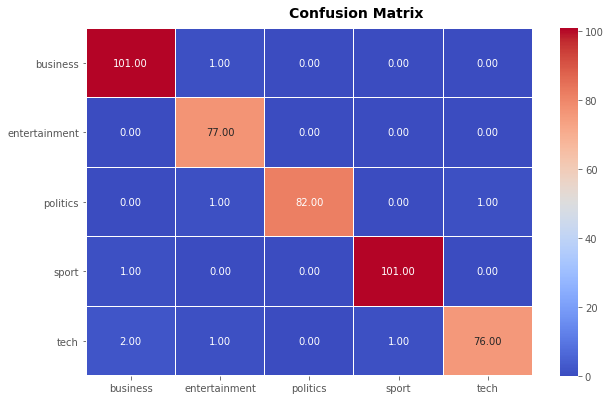

In [106]:
confusion_matrix_seaborn(y_test_raw, y_pred, lb.classes_)

In [185]:
print(classification_report(y_test_raw, y_pred))

               precision    recall  f1-score   support

     business       0.97      0.99      0.98       102
entertainment       0.96      1.00      0.98        77
     politics       1.00      0.98      0.99        84
        sport       0.99      0.99      0.99       102
         tech       0.99      0.95      0.97        80

    micro avg       0.98      0.98      0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



## Random Forest Classifier

In [164]:
rfc = RandomForestClassifier(n_estimators=200, oob_score=True, min_samples_leaf=4, max_features=700, n_jobs=-1)

In [165]:
%%time
rfc.fit(X_train, y_train_raw)

CPU times: user 3.33 s, sys: 31.2 ms, total: 3.36 s
Wall time: 1.88 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=700, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [166]:
train_acc = rfc.score(X_train, y_train_raw)

In [167]:
y_pred_rfc = rfc.predict(X_test)
test_acc = accuracy_score(y_test_raw, y_pred_rfc)

In [168]:
print(f"Training accuracy: {train_acc*100:.2f}%")
print(f"Test accuracy: {test_acc*100:.2f}%")

Training accuracy: 99.21%
Test accuracy: 95.28%


In [169]:
# get the predictions of each individual tree on each sample
test_preds = np.stack([tree.predict(X_test) for tree in rfc.estimators_])
test_preds.shape

(200, 445)

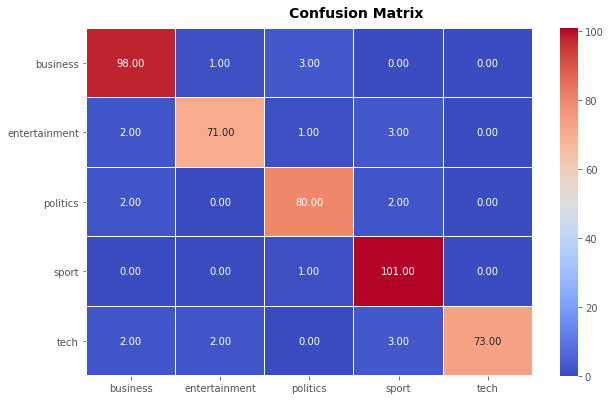

In [247]:
confusion_matrix_seaborn(y_test_raw, y_pred_rfc, lb.classes_)

In [187]:
print(classification_report(y_test_raw, y_pred_rfc))

               precision    recall  f1-score   support

     business       0.94      0.96      0.95       102
entertainment       0.95      0.95      0.95        77
     politics       0.95      0.95      0.95        84
        sport       0.94      0.99      0.97       102
         tech       0.99      0.90      0.94        80

    micro avg       0.95      0.95      0.95       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445



## Logistic Regression, Multinomial Naive Bayes, Linear SVC, Random Forest Classifier

In [312]:
%%time
models = [RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1),
          LogisticRegression(random_state=1310, n_jobs=-1), 
          LinearSVC(random_state=1310),
          MultinomialNB()]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, 
                                 np.concatenate((X_train.toarray(), X_test.toarray())), np.concatenate((y_train_raw.values, y_test_raw.values)), 
                                 cv=CV, scoring='accuracy')
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/suneel/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/suneel/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/suneel/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/suneel/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/suneel/miniconda3/envs/nlp/lib/

CPU times: user 17.4 s, sys: 58 s, total: 1min 15s
Wall time: 1min 54s


In [313]:
cv_df.groupby('model_name')['accuracy'].mean()

model_name
LinearSVC                 0.982933
LogisticRegression        0.975739
MultinomialNB             0.973929
RandomForestClassifier    0.966295
Name: accuracy, dtype: float64

In [314]:
lsvc = LinearSVC()
lsvc.fit(X_train, y_train_raw)
y_pred_lsvc = lsvc.predict(X_test)

In [318]:
train_acc_lsvc = lsvc.score(X_train, y_train_raw)
test_acc_lsvc = accuracy_score(y_test_raw, y_pred_lsvc)

In [319]:
print(f"Training accuracy: {train_acc_lsvc*100:.2f}%")
print(f"Test accuracy: {test_acc_lsvc*100:.2f}%")

Training accuracy: 100.00%
Test accuracy: 98.43%


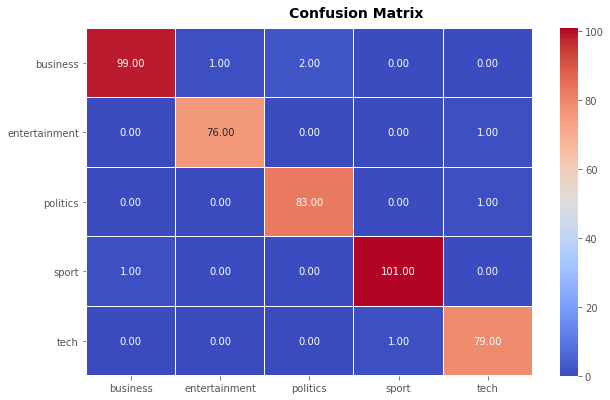

In [317]:
confusion_matrix_seaborn(y_test_raw, y_pred_lsvc, classes=lb.classes_)

In [320]:
print(classification_report(y_test_raw, y_pred_lsvc))

               precision    recall  f1-score   support

     business       0.99      0.97      0.98       102
entertainment       0.99      0.99      0.99        77
     politics       0.98      0.99      0.98        84
        sport       0.99      0.99      0.99       102
         tech       0.98      0.99      0.98        80

    micro avg       0.98      0.98      0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



## References:
+ Some part of tokenization is taken from, https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
+ https://developers.google.com/machine-learning/guides/text-classification/
+ http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/
+ https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle